In [ ]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/2025s2-iud-pre-processed-data/final_dataset.csv


In [ ]:
# Adjust file path if needed
FILE = "Data/Annual_Resort.csv"
df = pd.read_csv(FILE)

# Standardize visitor column
df = df.rename(columns={"Maximum temperature (Degree C)": "MaxTemp",
                        "Minimum temperature (Degree C)": "MinTemp",
                        "Rainfall amount (millimetres)": "Rainfall"})

df = df[["Year","SkiWeek","Resort","Visitors"]].copy()

# Clean types
df["Year"] = df["Year"].astype(int)
df["SkiWeek"] = df["SkiWeek"].astype(int)
df["Resort"] = df["Resort"].astype("category")
df["Visitors"] = pd.to_numeric(df["Visitors"], errors="coerce")

# Drop bad rows
df = df.dropna(subset=["Visitors"])
df = df[df["Visitors"] > 0]
df = df.sort_values(["Resort","Year","SkiWeek"]).reset_index(drop=True)

print(df.dtypes)
print("Years span:", df["Year"].min(), "→", df["Year"].max())
print("Resorts:", df["Resort"].unique())
df.head()


Year           int64
SkiWeek        int64
Resort      category
Visitors       int64
dtype: object
Years span: 2014 → 2024
Resorts: ['Charlotte Pass', 'Falls Creek', 'Mt. Baw Baw', 'Mt. Buller', 'Mt. Hotham', 'Perisher', 'Selwyn', 'Thredbo']
Categories (8, object): ['Charlotte Pass', 'Falls Creek', 'Mt. Baw Baw', 'Mt. Buller', 'Mt. Hotham', 'Perisher', 'Selwyn', 'Thredbo']


,Year,SkiWeek,Resort,Visitors
0,2014,1,Charlotte Pass,408
1,2014,2,Charlotte Pass,151
2,2014,3,Charlotte Pass,230
3,2014,4,Charlotte Pass,1134
4,2014,5,Charlotte Pass,3403


In [ ]:
# Feature engineering + split

W = int(df["SkiWeek"].max())  
year0 = int(df["Year"].min()) 

def add_time_features(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    # continuous week counter since start
    out["TimeIndex"] = (out["Year"] - year0) * W + out["SkiWeek"]
    # seasonality encoding
    out["sin_w"] = np.sin(2 * np.pi * out["SkiWeek"] / W)
    out["cos_w"] = np.cos(2 * np.pi * out["SkiWeek"] / W)
    return out

df_f = add_time_features(df)

# 2) Train = up to 2022, Test = 2023–24
train = df_f[df_f["Year"] <= 2022].copy()
test  = df_f[df_f["Year"] > 2022].copy()

print("Train years:", train["Year"].min(), "→", train["Year"].max())
print("Test years :", test["Year"].min(), "→", test["Year"].max())

train.head()


Train years: 2014 → 2022
Test years : 2023 → 2024


,Year,SkiWeek,Resort,Visitors,TimeIndex,sin_w,cos_w
0,2014,1,Charlotte Pass,408,1,0.406737,0.913545
1,2014,2,Charlotte Pass,151,2,0.743145,0.669131
2,2014,3,Charlotte Pass,230,3,0.951057,0.309017
3,2014,4,Charlotte Pass,1134,4,0.994522,-0.104528
4,2014,5,Charlotte Pass,3403,5,0.866025,-0.500000


In [4]:
# STEP 3 — Model training (Visitors only)

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Features & target
feature_cols = ["Year","SkiWeek","TimeIndex","sin_w","cos_w","Resort"]
target_col = "Visitors"

X_train = train[feature_cols]
y_train = train[target_col]
X_test  = test[feature_cols]
y_test  = test[target_col]

# Preprocessing: polynomial on numeric, OHE on Resort
numeric_cols = ["Year","SkiWeek","TimeIndex","sin_w","cos_w"]
cat_cols     = ["Resort"]

pre = ColumnTransformer(
    transformers=[
        ("poly", PolynomialFeatures(degree=2, include_bias=False), numeric_cols),
        ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

# Model: Ridge regression (tune alpha if needed)
ridge = Ridge(alpha=3.0, random_state=42)

model = Pipeline([
    ("pre", pre),
    ("ridge", ridge)
])

# Fit
model.fit(X_train, y_train)

# Evaluate on test set (2023–24)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"Visitors | RMSE={rmse:.2f} | R2={r2:.3f}")


Visitors | RMSE=11928.79 | R2=0.596


In [5]:
# STEP 4 — Forecast Visitors for 2026

# 1) Build future grid for 2026 (all resorts × all ski weeks)
resorts = df["Resort"].unique()
weeks   = sorted(df["SkiWeek"].unique())

future_2026 = pd.DataFrame(
    [{"Year": 2026, "SkiWeek": w, "Resort": r} for r in resorts for w in weeks]
)

# 2) Add time features
future_2026 = add_time_features(future_2026)

# 3) Predict with trained model
X_future = future_2026[feature_cols]
future_2026["Pred_Visitors"] = np.rint(model.predict(X_future)).astype(int)

# 4) Save to CSV
future_2026.to_csv("predicted_visitors_2026.csv", index=False)
print("✅ 2026 forecast saved as predicted_visitors_2026.csv")

# Preview
future_2026.head(12)

✅ 2026 forecast saved as predicted_visitors_2026.csv


,Year,SkiWeek,Resort,TimeIndex,sin_w,cos_w,Pred_Visitors
0,2026,1,Charlotte Pass,181,0.406737,0.913545,4450
1,2026,2,Charlotte Pass,182,0.743145,0.669131,698
2,2026,3,Charlotte Pass,183,0.951057,0.309017,5459
3,2026,4,Charlotte Pass,184,0.994522,-0.104528,11764
4,2026,5,Charlotte Pass,185,0.866025,-0.500000,14179
5,2026,6,Charlotte Pass,186,0.587785,-0.809017,11138
6,2026,7,Charlotte Pass,187,0.207912,-0.978148,4966
7,2026,8,Charlotte Pass,188,-0.207912,-0.978148,-288
8,2026,9,Charlotte Pass,189,-0.587785,-0.809017,-1745
9,2026,10,Charlotte Pass,190,-0.866025,-0.500000,552


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

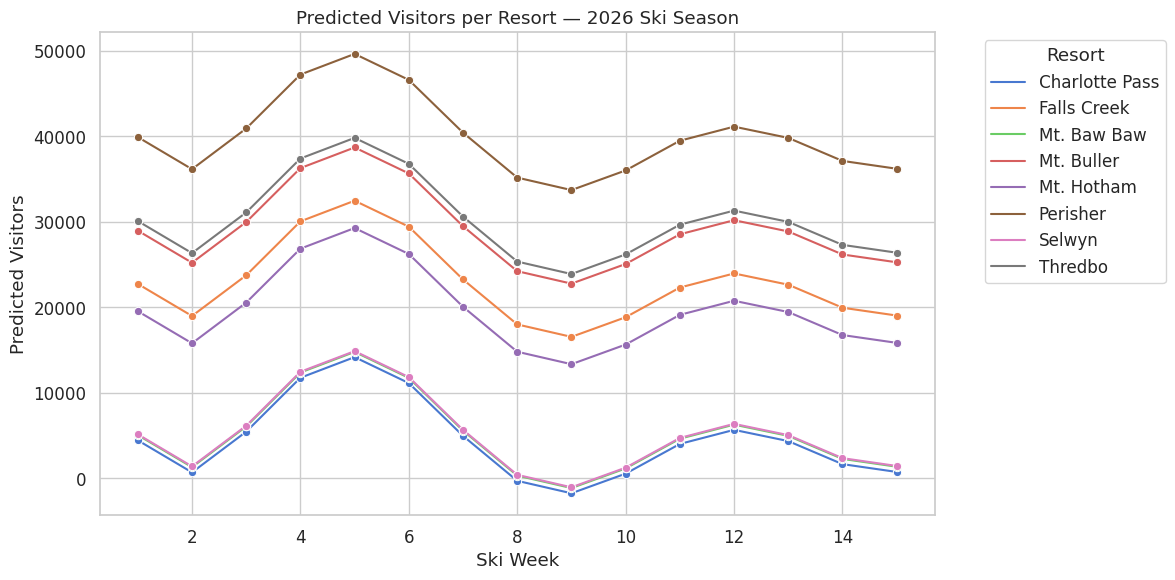

In [6]:
# STEP 5 — Plot 2026 visitor predictions
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=future_2026,
    x="SkiWeek", y="Pred_Visitors", hue="Resort", marker="o"
)
plt.title("Predicted Visitors per Resort — 2026 Ski Season")
plt.ylabel("Predicted Visitors")
plt.xlabel("Ski Week")
plt.legend(title="Resort", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
y_pred = model.predict(X_test)

# Metrics
r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print("=== Visitor Prediction Validity Metrics (Test: 2023–24) ===")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:.2f} visitors")
print(f"MAE  : {mae:.2f} visitors")

=== Visitor Prediction Validity Metrics (Test: 2023–24) ===
R²   : 0.596
RMSE : 11928.79 visitors
MAE  : 9414.03 visitors


## Method  
- Cleaned data (removed bad rows, zero visitors).  
- Added **TimeIndex** (trend) + **seasonal features** (sin/cos of week).  
- Model: **Ridge regression** (good for extrapolation).  
- Train on ≤2022, test on 2023–24.  

---

## Model Performance (2023–24 test)  
- **R² = 0.60**  
- **RMSE ≈ 11.9k visitors**  
- **MAE ≈ 9.4k visitors**  
Captures season shape well, less accurate in small/edge weeks.  
